In [3]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
df = pd.read_csv("Huntington_Disease_Dataset.csv")
display(df.head())
display(df.info())

,Patient_ID,Age,Sex,Family_History,HTT_CAG_Repeat_Length,Motor_Symptoms,Cognitive_Decline,Chorea_Score,Brain_Volume_Loss,Functional_Capacity,...,HTT_Gene_Expression_Level,Protein_Aggregation_Level,Random_Protein_Sequence,Random_Gene_Sequence,Disease_Stage,Gene/Factor,Chromosome_Location,Function,Effect,Category
0,b2a49170-8561-4665-9371-2240b55dd87a,31,Male,No,67,Moderate,Severe,8.80,3.20,94,...,1.67,0.58,DAHKIRSPMRVGPHYYAQCDNNDTGSDKEHWLKTEAAPMTMDRTVE...,GCCAGCAGCGCCCGAGCGTATGAGGTATATGGATTGGACATTGGGC...,Middle,HTT,4p16.3,CAG Trinucleotide Repeat Expansion,Neurodegeneration,Primary Cause
1,f5fae45d-8718-41c4-a957-6928f79f3c8e,33,Female,Yes,38,Severe,Moderate,3.24,5.98,50,...,0.18,0.30,PANGFWYHNCLRFWNIPPYVMEGFPLADITEVHKWRVSGFMCWETQ...,AGTTTTCAGTGAGACTCTTCCCCAAAAGCCTCCACTACGACAGTGT...,Pre-Symptomatic,HTT,4p16.3,CAG Trinucleotide Repeat Expansion,Neurodegeneration,Primary Cause
2,66ab0567-050b-4d56-9ec4-b676309899a6,69,Male,Yes,37,Severe,Moderate,1.01,2.82,69,...,0.90,1.04,NWHEGHGASTWKATMVAWCLMVQHAVTWKEGNTRCREMSCMNFTQL...,TATACCACCAGTGGGAAGAGTAACGATTTTGGAGCGCCCCGAGTCC...,Early,MSH3,5q14.1,Mismatch Repair,CAG Repeat Expansion,Trans-acting Modifier
3,996a48e4-e841-418f-a539-5a7a86cd815d,66,Male,Yes,50,Mild,Severe,3.21,6.77,76,...,1.16,1.87,KCVQYIQATQMLVQSWGQRNPIMQSSEPDRAHDYESGTPKTYTYML...,GCGCGACCGACCAAAGGACCCATGGTGGTGATCTGTCATTGGATTC...,Pre-Symptomatic,MSH3,5q14.1,Mismatch Repair,CAG Repeat Expansion,Trans-acting Modifier
4,d45c7ca8-7125-4aaa-8018-5bbc60d35a1f,43,Female,Yes,48,Moderate,Mild,2.31,7.53,70,...,1.85,2.94,DQPGNMTRQNKNHCMWRAKRPTKHPGHKPGEIDKEKSEQNDADSSA...,GGGACCGCGGTTCTAGAAGAGAGGTTCTCTGACCGCCGAAGGATTC...,Late,HTT (Somatic Expansion),4p16.3,CAG Repeat Instability,Faster Disease Onset,Cis-acting Modifier


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48536 entries, 0 to 48535
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient_ID                 48536 non-null  object 
 1   Age                        48536 non-null  int64  
 2   Sex                        48536 non-null  object 
 3   Family_History             48536 non-null  object 
 4   HTT_CAG_Repeat_Length      48536 non-null  int64  
 5   Motor_Symptoms             48536 non-null  object 
 6   Cognitive_Decline          36417 non-null  object 
 7   Chorea_Score               48536 non-null  float64
 8   Brain_Volume_Loss          48536 non-null  float64
 9   Functional_Capacity        48536 non-null  int64  
 10  Gene_Mutation_Type         48536 non-null  object 
 11  HTT_Gene_Expression_Level  48536 non-null  float64
 12  Protein_Aggregation_Level  48536 non-null  float64
 13  Random_Protein_Sequence    48536 non-null  obj

None

In [4]:
df['Family_History_Bin'] = df['Family_History'].apply(lambda x: 1 if x=="Yes" else 0)
df['Sex_Female'] = df['Sex'].apply(lambda x: 1 if x.strip().lower() == "female" else 0)
features_q1 = [
    'Age', 
    'Sex_Female', 
    'HTT_CAG_Repeat_Length', 
    'Chorea_Score', 
    'Functional_Capacity', 
    'Protein_Aggregation_Level'
]

df_q1 = df.dropna(subset=features_q1 + ['Family_History_Bin']).copy()
features_q2 = [
    'Age', 
    'HTT_CAG_Repeat_Length', 
    'Functional_Capacity',
    'Protein_Aggregation_Level'
]
outcomes_q2 = [
    'Chorea_Score', 
    'Brain_Volume_Loss'
]
df_q2 = df.dropna(subset=features_q2 + outcomes_q2).copy()
def make_severity_binary(x):
    if isinstance(x, str) and x.strip().lower() == "severe":
        return 1
    else:
        return 0
df['Motor_Symptoms_Sev'] = df['Motor_Symptoms'].apply(make_severity_binary)
df['Cognitive_Decline_Sev'] = df['Cognitive_Decline'].apply(make_severity_binary)
features_q3 = [
    'Age', 
    'Sex_Female',
    'HTT_CAG_Repeat_Length', 
    'Chorea_Score', 
    'Functional_Capacity', 
    'Protein_Aggregation_Level'
]
outcomes_q3 = [
    'Motor_Symptoms_Sev',
    'Cognitive_Decline_Sev'
]
df_q3 = df.dropna(subset=features_q3 + outcomes_q3).copy()
print("Q1 dataset shape:", df_q1.shape)
print("Q2 dataset shape:", df_q2.shape)
print("Q3 dataset shape:", df_q3.shape)


Q1 dataset shape: (48536, 23)
Q2 dataset shape: (48536, 23)
Q3 dataset shape: (48536, 25)


In [5]:
X_q1 = df_q1[features_q1].values
y_q1 = df_q1['Family_History_Bin'].values

X_q2 = df_q2[features_q2].values
y_q2 = df_q2[outcomes_q2].values

X_q3 = df_q3[features_q3].values
y_q3 = df_q3[outcomes_q3].values

In [13]:
X_q1_raw = df_q1[features_q1].values.astype(float)
# Compute mean and std for each column
means = X_q1_raw.mean(axis=0)
stds = X_q1_raw.std(axis=0)
# Guard against zero std
stds[stds == 0.0] = 1.0  
X_q1_std = (X_q1_raw - means) / stds

y_q1 = df_q1['Family_History_Bin'].values.astype(int)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 121 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.011,0.009,-0.006,0.028,0.0,0.0,6239.0,3029.0,1.0
beta[1],0.007,0.009,-0.009,0.023,0.0,0.0,7552.0,3217.0,1.0
beta[2],-0.004,0.009,-0.021,0.014,0.0,0.0,5992.0,3171.0,1.0
beta[3],-0.004,0.009,-0.022,0.012,0.0,0.0,6109.0,2691.0,1.0
beta[4],0.015,0.009,-0.002,0.032,0.0,0.0,6809.0,2766.0,1.0
beta[5],0.003,0.009,-0.014,0.020,0.0,0.0,5940.0,3009.0,1.0
intercept,0.005,0.009,-0.012,0.022,0.0,0.0,7776.0,3264.0,1.0


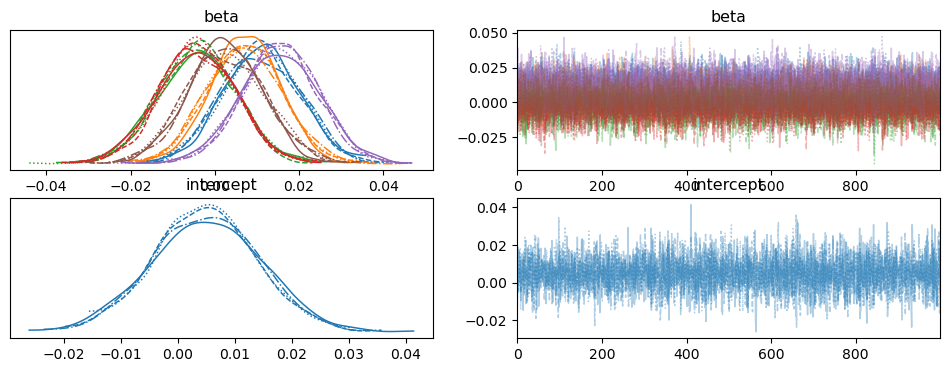

In [ ]:
with pm.Model() as logistic_model_q1:
    beta = pm.Normal("beta", mu=0, sigma=.5, shape=X_q1_std.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=.5)
    
    logits = intercept + pm.math.dot(X_q1_std, beta)
    p = pm.math.sigmoid(logits)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_q1)
    
    # 4. Sample
    idata_q1 = pm.sample(
        draws=1000, 
        tune=2000, 
        chains=4, 
        target_accept=0.95,
        random_seed=42,
        cores=1
    )
az.plot_trace(idata_q1, var_names=["beta", "intercept"])
az.summary(idata_q1, var_names=["beta", "intercept"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, intercept, packed_L]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 171 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.000,0.001,-0.001,0.002,0.000,0.000,1619.0,1666.0,1.00
"betas[0, 1]",-0.000,0.001,-0.001,0.001,0.000,0.000,1409.0,1280.0,1.00
"betas[1, 0]",0.001,0.001,-0.001,0.003,0.000,0.000,1279.0,1266.0,1.00
"betas[1, 1]",-0.001,0.001,-0.002,0.000,0.000,0.000,1143.0,1194.0,1.00
"betas[2, 0]",-0.000,0.000,-0.001,0.001,0.000,0.000,1948.0,1606.0,1.00
"betas[2, 1]",0.000,0.000,-0.000,0.001,0.000,0.000,2206.0,1447.0,1.00
"betas[3, 0]",-0.025,0.009,-0.043,-0.009,0.000,0.000,1969.0,1529.0,1.00
"betas[3, 1]",0.017,0.006,0.007,0.029,0.000,0.000,2349.0,1375.0,1.00
intercept[0],5.003,0.081,4.845,5.149,0.003,0.002,1040.0,1295.0,1.00
intercept[1],5.288,0.053,5.195,5.391,0.002,0.001,812.0,1092.0,1.01


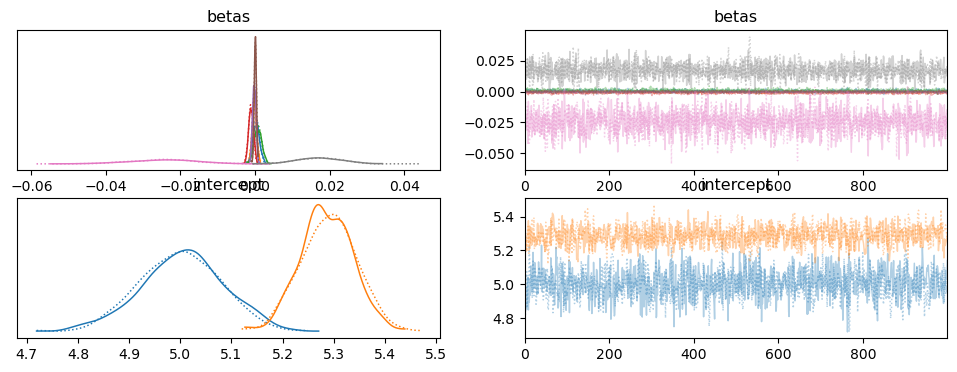

In [15]:
X_data = X_q2
Y_data = y_q2

n, p = X_data.shape
m = Y_data.shape[1]

with pm.Model() as multivar_reg_q2:
    
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    
    intercept = pm.Normal("intercept", mu=0, sigma=1, shape=m)
    packed_L = pm.LKJCholeskyCov(
        "packed_L",
        n=m, 
        eta=2.0, 
        sd_dist=pm.Exponential.dist(1.0, shape=m), 
        compute_corr=False
    )
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))
    
    mu = pm.math.dot(X_data, betas) + intercept
    y_obs = pm.MvNormal("y_obs",
                        mu=mu,
                        chol=L,
                        observed=Y_data)
    
    idata_q2 = pm.sample(
        draws=1000, 
        tune=1000, 
        chains=4, 
        target_accept=0.9,
        random_seed=42
    )

# Diagnostics
az.plot_trace(idata_q2, var_names=["betas", "intercept"])
az.summary(idata_q2, var_names=["betas", "intercept", "Sigma"])

In [19]:
X_q3_raw = df_q3[features_q3].values.astype(float)
means = X_q3_raw.mean(axis=0)
stds = X_q3_raw.std(axis=0)
stds[stds==0] = 1.0
X_q3_std = (X_q3_raw - means) / stds

Y_q3 = df_q3[outcomes_q3].values.astype(int)

In [ ]:
n, p = X_q3_std.shape
m = Y_q3.shape[1]

with pm.Model() as multi_class_q3:
    L, R, std = pm.LKJCholeskyCov(
        "R", n=m, eta=2.0, 
        sd_dist=pm.Exponential.dist(1.0, shape=m),
        compute_corr=True
    )
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    mu = pm.math.dot(X_q3_std, betas)
    z = pm.MvNormal("z", mu=mu, cov=R, shape=(n, m))
    p = pm.math.invprobit(z)
    y = pm.Bernoulli("y", p=p, observed=Y_q3)
    
    idata_q3 = pm.sample(
        draws=1000,
        tune=2000,
        chains=4,
        target_accept=0.95,
        random_seed=42
    )

# Diagnostics
az.plot_trace(idata_q3, var_names=["betas", "R_corr"])
az.summary(idata_q3, var_names=["betas", "R_corr"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Output()

In [ ]:
df_q3_small = df_q3.sample(n=300, random_state=42)
X_q3_raw = df_q3_small[features_q3].values.astype(float)
means = X_q3_raw.mean(axis=0)
stds = X_q3_raw.std(axis=0)
stds[stds==0] = 1.0
X_q3_std = (X_q3_raw - means) / stds
Y_q3 = df_q3_small[outcomes_q3].values.astype(int)


In [ ]:
n, p = X_q3_std.shape
m = Y_q3.shape[1]

with pm.Model() as multi_class_q3:
    L, R, std = pm.LKJCholeskyCov(
        "R", n=m, eta=2.0, 
        sd_dist=pm.Exponential.dist(1.0, shape=m),
        compute_corr=True
    )
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    mu = pm.math.dot(X_q3_std, betas)
    z = pm.MvNormal("z", mu=mu, cov=R, shape=(n, m))
    p = pm.math.invprobit(z)
    y = pm.Bernoulli("y", p=p, observed=Y_q3)
    
    idata_q3 = pm.sample(
        draws=1000,
        tune=2000,
        chains=4,
        target_accept=0.95,
        random_seed=42
    )

# Diagnostics
az.plot_trace(idata_q3, var_names=["betas", "R_corr"])
az.summary(idata_q3, var_names=["betas", "R_corr"])